# Installs & Imports

In [1]:
!pip install -q numpyro

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.9/370.9 kB 27.1 MB/s eta 0:00:00


In [2]:
from __future__ import annotations
from typing import Optional, Tuple, Iterable, Union, Dict, List, Literal

import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
from jax import lax
import numpyro
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO, Predictive, autoguide
from numpyro.optim import ClippedAdam
from numpyro.handlers import scale as np_scale
import matplotlib.pyplot as plt
from dataclasses import dataclass

ArrayLike = Union[np.ndarray, Iterable[float], list]

# Utilities

In [3]:
def to_one_dim_float(
    x: ArrayLike
) -> np.ndarray:
    arr = np.asarray(
        x,
        dtype=np.float32
    ).reshape(-1)
    if arr.ndim != 1:
        raise ValueError("Target y must be 1D.")
    return arr

In [4]:
def to_two_dim_float(
    x: Optional[ArrayLike]
) -> np.ndarray:
    if x is None:
        return np.zeros(
            (0, 0),
            dtype=np.float32
        )
    arr = np.asarray(
        x,
        dtype=np.float32
    )
    if arr.ndim == 1:
        arr = arr[:, None]
    return arr

In [5]:
def make_windows_one_step(
    y: np.ndarray,
    X: np.ndarray,
    L: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    n = len(y)
    if n <= L:
        raise ValueError("Need at least L+1 points.")
    m = n - L
    y_ctx = np.stack([y[i:i+L] for i in range(m)], 0)
    y_next = y[L:][:, None]
    if X.size == 0:
        x_ctx = np.zeros(
            (m, L, 0),
            np.float32
        )
        x_next = np.zeros(
            (m, 1, 0),
            np.float32
        )
    else:
        x_ctx = np.stack([X[i:i+L] for i in range(m)], 0)
        x_next = X[L:][:, None, :]
    return (
        y_ctx.astype(np.float32),
        x_ctx.astype(np.float32),
        y_next.astype(np.float32),
        x_next.astype(np.float32)
    )

In [6]:
def xavier_uniform(
    key: jax.Array,
    shape: Tuple[int, ...],
    gain: float=1.0
) -> jnp.ndarray:
    if len(shape) < 2:
        fan_in = float(shape[0])
        fan_out = float(shape[0])
    else:
        fan_in = float(shape[-2])
        fan_out = float(shape[-1])
    limit = gain * np.sqrt(
        6.0 / (fan_in + fan_out + 1e-8)
    )
    return jax.random.uniform(
        key,
        shape=shape,
        minval=-limit,
        maxval=limit
    )

In [7]:
def ln1d(
    x: jnp.ndarray,
    gamma: jnp.ndarray,
    beta: jnp.ndarray,
    eps: float=1e-5
) -> jnp.ndarray:
    m = x.mean(
        axis=-1,
        keepdims=True
    )
    v = jnp.mean(
        (x - m) ** 2,
        axis=-1,
        keepdims=True
    )
    xhat = (x - m) / jnp.sqrt(
        v + eps
    )
    return gamma * xhat + beta

In [8]:
class KeyGen:
    def __init__(
        self,
        key: Optional[jax.Array]
    ):
        self.key = key
    def next(
        self
    ) -> Optional[jax.Array]:
        if self.key is None:
            return None
        self.key, sub = jax.random.split(self.key)
        return sub

In [9]:
def variational_mask(
    key: Optional[jax.Array],
    shape: Tuple[int, ...],
    rate: float,
    training: bool
) -> Optional[jnp.ndarray]:
    if (not training) or key is None or rate <= 0.0:
        return None
    keep = 1.0 - float(rate)
    m = jax.random.bernoulli(
        key,
        keep,
        shape
    ).astype(jnp.float32) / keep
    return m

In [10]:
def compute_metrics(
    y_true: np.ndarray,
    y_pred: np.ndarray
) -> Dict[str, float]:
    y_true = np.asarray(
        y_true,
        np.float32
    ).reshape(-1)
    y_pred = np.asarray(
        y_pred,
        np.float32
    ).reshape(-1)
    mae = float(np.mean(np.abs(y_true - y_pred)))
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    denom = np.maximum(
        np.abs(y_true),
        1e-8
    )
    mape = float(np.mean(np.abs(y_true - y_pred) / denom))
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

In [11]:
def _make_time_features(
    n: int,
    weekly_periods: Iterable[float]=(52.0, 26.0, 13.0)
) -> np.ndarray:
    t = np.arange(
        n,
        dtype=np.float32
    )
    trend = (t - t.mean()) / (t.std() + 1e-6)
    feats = [trend]
    for p in weekly_periods:
        feats += [
            np.sin(2 * np.pi * t / float(p)),
            np.cos(2 * np.pi * t / float(p))
        ]
    return np.column_stack(feats).astype(np.float32)

In [12]:
def load_or_synthesize_weekly_co2(
) -> Tuple[np.ndarray, np.ndarray]:
    try:
        from statsmodels.datasets import co2
        co2_df = co2.load_pandas().data["co2"].astype(np.float32)
        y_full = np.asarray(
            co2_df.interpolate().values,
            np.float32
        )
        X_full = _make_time_features(len(y_full))
        return y_full, X_full
    except Exception:
        n = 1500
        t = np.arange(
            n,
            dtype=np.float32
        )
        rng = np.random.default_rng(0)
        season = 2.0 * np.sin(2 * np.pi * t / 52.0) + 1.0 * np.sin(2 * np.pi * t / 26.0)
        trend = 0.002 * t
        X_full = _make_time_features(n)
        y_full = (
            trend + season + 0.8 * X_full[:, 1] + rng.normal(0, 0.5, size=n)
        ).astype(np.float32)
        return y_full, X_full

In [13]:
@dataclass
class Standardizer:
    y_mu: float
    y_sd: float
    X_mu: Optional[np.ndarray]
    X_sd: Optional[np.ndarray]

    @classmethod
    def fit(
        cls,
        y_train: np.ndarray,
        X_train: np.ndarray
    ) -> "Standardizer":
        y_mu = float(np.mean(y_train))
        y_sd = float(np.std(y_train) + 1e-6)
        if X_train.size:
            X_mu = np.mean(X_train, 0)
            X_sd = np.std(X_train, 0) + 1e-6
        else:
            X_mu, X_sd = None, None
        return cls(y_mu, y_sd, X_mu, X_sd)

    def transform_y(
        self,
        y: np.ndarray
    ) -> np.ndarray:
        return (y - self.y_mu) / self.y_sd

    def transform_X(
        self,
        X: np.ndarray
    ) -> np.ndarray:
        if X.size == 0 or self.X_mu is None:
            return X
        return (X - self.X_mu) / self.X_sd

    def inverse_y(
        self,
        y_std: np.ndarray
    ) -> np.ndarray:
        return y_std * self.y_sd + self.y_mu

In [14]:
def _to_region_series(
    mean: np.ndarray,
    lo: Optional[np.ndarray],
    hi: Optional[np.ndarray],
    start_idx: int,
    total_len: int
) -> Tuple[np.ndarray, Optional[np.ndarray], Optional[np.ndarray]]:
    seg_len = int(len(mean))
    start = int(max(0, start_idx))
    end = int(min(start + seg_len, total_len))
    copy_len = max(0, end - start)

    out_m = np.full(
        total_len,
        np.nan,
        dtype=np.float32
    )
    if copy_len > 0:
        out_m[start:end] = mean[:copy_len].astype(np.float32)

    if lo is not None and hi is not None:
        out_l = np.full(
            total_len,
            np.nan,
            dtype=np.float32
        )
        out_h = np.full(
            total_len,
            np.nan,
            dtype=np.float32
        )
        if copy_len > 0:
            out_l[start:end] = lo[:copy_len].astype(np.float32)
            out_h[start:end] = hi[:copy_len].astype(np.float32)
    else:
        out_l, out_h = None, None

    return out_m, out_l, out_h

# LSTM Architecture

In [15]:
def make_W_r_orthogonal_concat4(
    key: jax.Array,
    Pdim: int,
    H: int
) -> jnp.ndarray:
    ks = jax.random.split(key, 4)

    def ortho_block(
        k_: jax.Array
    ) -> jnp.ndarray:
        if Pdim <= H:
            A = jax.random.normal(
                k_,
                (H, Pdim)
            )
            q, _ = jnp.linalg.qr(
                A,
                mode="reduced"
            )
            return q.T.astype(jnp.float32)
        else:
            A = jax.random.normal(
                k_,
                (Pdim, H)
            )
            q, _ = jnp.linalg.qr(
                A,
                mode="reduced"
            )
            return q.astype(jnp.float32)

    Wi = ortho_block(ks[0])
    Wf = ortho_block(ks[1])
    Wg = ortho_block(ks[2])
    Wo = ortho_block(ks[3])
    return jnp.concatenate([Wi, Wf, Wg, Wo], axis=1)

In [16]:
class LSTMCellLNProj:
    """
    LayerNorm LSTM cell with optional projection.
    If proj_size is None => vanilla LN-LSTM (P = H, no W_proj, r_t = m_t).
    """
    def __init__(
        self,
        hidden_dim: int,
        proj_size: Optional[int],
        ln_eps: float=1e-5,
        cell_clip: Optional[float]=None,
        proj_clip: Optional[float]=None,
        name: str="lstmcell"
    ):
        self.H = int(hidden_dim)
        self.P = int(proj_size) if proj_size is not None else self.H
        self.use_proj = proj_size is not None
        self.ln_eps = float(ln_eps)
        self.cell_clip = None if cell_clip is None else float(cell_clip)
        self.proj_clip = None if proj_clip is None else float(proj_clip)
        self.name = name

    def create_params(
        self,
        Din: int,
        layer: int
    ) -> Dict[str, jnp.ndarray]:
        nm = f"{self.name}:{layer}"
        W_in = numpyro.param(
            f"{nm}:W_in",
            xavier_uniform(
                jax.random.PRNGKey(1000 + layer),
                (Din, 4 * self.H)
            )
        )
        W_r = numpyro.param(
            f"{nm}:W_r",
            make_W_r_orthogonal_concat4(
                jax.random.PRNGKey(10000 + layer),
                self.P,
                self.H
            )
        )
        if self.use_proj:
            W_proj = numpyro.param(
                f"{nm}:W_proj",
                xavier_uniform(
                    jax.random.PRNGKey(2000 + layer),
                    (self.H, self.P)
                )
            )
        else:
            W_proj = None

        ln_i_g = numpyro.param(
            f"{nm}:ln_i_g",
            jnp.ones((self.H,), jnp.float32)
        )
        ln_i_b = numpyro.param(
            f"{nm}:ln_i_b",
            jnp.zeros((self.H,), jnp.float32)
        )

        ln_f_g = numpyro.param(
            f"{nm}:ln_f_g",
            jnp.ones((self.H,), jnp.float32)
        )
        ln_f_b = numpyro.param(
            f"{nm}:ln_f_b",
            jnp.full(
                (self.H,),
                2.0,
                jnp.float32
            )
        )

        ln_g_g = numpyro.param(
            f"{nm}:ln_g_g",
            jnp.ones((self.H,), jnp.float32)
        )
        ln_g_b = numpyro.param(
            f"{nm}:ln_g_b",
            jnp.zeros((self.H,), jnp.float32)
        )

        ln_o_g = numpyro.param(
            f"{nm}:ln_o_g",
            jnp.ones((self.H,), jnp.float32)
        )
        ln_o_b = numpyro.param(
            f"{nm}:ln_o_b",
            jnp.zeros((self.H,), jnp.float32)
        )

        ln_c_g = numpyro.param(
            f"{nm}:ln_c_g",
            jnp.ones((self.H,), jnp.float32)
        )
        ln_c_b = numpyro.param(
            f"{nm}:ln_c_b",
            jnp.zeros((self.H,), jnp.float32)
        )

        assert W_in.shape == (Din, 4 * self.H)
        assert W_r.shape == (self.P, 4 * self.H)
        if self.use_proj:
            assert W_proj is not None and W_proj.shape == (self.H, self.P)

        return {
            "W_in": W_in,
            "W_r": W_r,
            "W_proj": W_proj,
            "ln_i_g": ln_i_g,
            "ln_i_b": ln_i_b,
            "ln_f_g": ln_f_g,
            "ln_f_b": ln_f_b,
            "ln_g_g": ln_g_g,
            "ln_g_b": ln_g_b,
            "ln_o_g": ln_o_g,
            "ln_o_b": ln_o_b,
            "ln_c_g": ln_c_g,
            "ln_c_b": ln_c_b
        }

    def step(
        self,
        r_prev: jnp.ndarray,
        c_prev: jnp.ndarray,
        x_t: jnp.ndarray,
        m_in: Optional[jnp.ndarray],
        m_rec: Optional[jnp.ndarray],
        params: Dict[str, jnp.ndarray]
    ) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
        W_in = params["W_in"]
        W_r = params["W_r"]
        W_proj = params["W_proj"]

        ln_i_g = params["ln_i_g"]
        ln_i_b = params["ln_i_b"]
        ln_f_g = params["ln_f_g"]
        ln_f_b = params["ln_f_b"]
        ln_g_g = params["ln_g_g"]
        ln_g_b = params["ln_g_b"]
        ln_o_g = params["ln_o_g"]
        ln_o_b = params["ln_o_b"]
        ln_c_g = params["ln_c_g"]
        ln_c_b = params["ln_c_b"]

        xin = x_t if m_in is None else x_t * m_in
        rmask = r_prev if m_rec is None else r_prev * m_rec

        g = (
            jnp.einsum(
                "bd,df->bf",
                xin,
                W_in
            )
            + jnp.einsum(
                "bp,pf->bf",
                rmask,
                W_r
            )
        )
        H = self.H
        gi = g[:, 0*H:1*H]
        gf = g[:, 1*H:2*H]
        gg = g[:, 2*H:3*H]
        go = g[:, 3*H:4*H]

        i = jax.nn.sigmoid(
            ln1d(
                gi,
                ln_i_g,
                ln_i_b,
                eps=self.ln_eps
            )
        )
        f = jax.nn.sigmoid(
            ln1d(
                gf,
                ln_f_g,
                ln_f_b,
                eps=self.ln_eps
            )
        )
        gtil = jnp.tanh(
            ln1d(
                gg,
                ln_g_g,
                ln_g_b,
                eps=self.ln_eps
            )
        )
        o = jax.nn.sigmoid(
            ln1d(
                go,
                ln_o_g,
                ln_o_b,
                eps=self.ln_eps
            )
        )

        c_t = f * c_prev + i * gtil
        if self.cell_clip is not None:
            c_t = jnp.clip(
                c_t,
                -self.cell_clip,
                self.cell_clip
            )

        c_tn = ln1d(
            c_t,
            ln_c_g,
            ln_c_b,
            eps=self.ln_eps
        )
        m_t = o * jnp.tanh(c_tn)

        if self.use_proj:
            r_t = jnp.einsum(
                "bh,hp->bp",
                m_t,
                W_proj
            )
            if self.proj_clip is not None:
                r_t = jnp.clip(
                    r_t,
                    -self.proj_clip,
                    self.proj_clip
                )
        else:
            r_t = m_t

        return r_t, c_t, m_t

In [17]:
class LSTMLayer:
    """
    One forward LSTM/LSTMP layer (scan over time) with variational masks.
    """
    def __init__(
        self,
        hidden_dim: int,
        proj_size: Optional[int],
        ln_eps: float=1e-5,
        input_dropout: float=0.1,
        recurrent_dropout: float=0.1,
        inter_layer_dropout: float=0.1,
        cell_clip: Optional[float]=None,
        proj_clip: Optional[float]=None,
        name: str="lstmlayer"
    ):
        self.cell = LSTMCellLNProj(
            hidden_dim,
            proj_size,
            ln_eps,
            cell_clip,
            proj_clip,
            name=f"{name}:cell"
        )
        self.in_drop = float(input_dropout)
        self.rec_drop = float(recurrent_dropout)
        self.inter_drop = float(inter_layer_dropout)
        self.name = name

    def init_params(
        self,
        Din: int,
        layer_index: int
    ) -> Dict[str, jnp.ndarray]:
        return self.cell.create_params(Din, layer_index)

    def run(
        self,
        x_seq: jnp.ndarray,
        enc_mask: jnp.ndarray,
        layer_index: int,
        params: Dict[str, jnp.ndarray],
        keygen: Optional[KeyGen],
        training: bool,
        apply_inter_dropout: bool,
        h0: Optional[jnp.ndarray]=None,
        c0: Optional[jnp.ndarray]=None
    ) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
        B, L, Din = x_seq.shape
        P = self.cell.P

        m_in = variational_mask(
            keygen.next() if keygen else None,
            (B, Din),
            self.in_drop,
            training
        )
        m_rec = variational_mask(
            keygen.next() if keygen else None,
            (B, P),
            self.rec_drop,
            training
        )
        m_inter = variational_mask(
            keygen.next() if keygen else None,
            (B, P),
            self.inter_drop,
            training
        ) if (training and apply_inter_dropout) else None

        r0 = jnp.zeros(
            (B, P),
            jnp.float32
        ) if h0 is None else h0
        c0 = jnp.zeros(
            (B, self.cell.H),
            jnp.float32
        ) if c0 is None else c0

        def step_fn(
            carry,
            xt_mt
        ):
            r_prev, c_prev = carry
            x_t, m_t = xt_mt
            r_t, c_t, _ = self.cell.step(
                r_prev,
                c_prev,
                x_t,
                m_in,
                m_rec,
                params
            )
            m = m_t[:, None]
            r_t_eff = jnp.where(
                m,
                r_t,
                r_prev
            )
            c_t_eff = jnp.where(
                m,
                c_t,
                c_prev
            )
            r_out = r_t_eff if m_inter is None else (r_t_eff * m_inter)
            return (r_t_eff, c_t_eff), r_out

        (rT, cT), R = lax.scan(
            step_fn,
            (r0, c0),
            (x_seq.swapaxes(0, 1), enc_mask.swapaxes(0, 1))
        )
        R = R.swapaxes(0, 1)
        return rT, cT, R

In [18]:
class LSTMLNProjBackbone:
    """
    Stacked LN-LSTM / LSTMP (forward only).
    - proj_size=None => vanilla LN-LSTM (P=H).
    - h0, c0: optional initial states for the first layer (applied to each layer if provided).
    - return_sequences: if True returns the top layer sequence (B, L, P); else final state (B, P).
    """
    def __init__(
        self,
        context_len: int,
        hidden_dim: int,
        proj_size: Optional[int],
        num_layers: int,
        ln_eps: float=1e-5,
        input_dropout: float=0.1,
        recurrent_dropout: float=0.1,
        inter_layer_dropout: float=0.1,
        cell_clip: Optional[float]=None,
        proj_clip: Optional[float]=None,
        name: str="lstm"
    ):
        self.L = int(context_len)
        self.H = int(hidden_dim)
        self.P = int(proj_size) if proj_size is not None else self.H
        self.Lr = int(num_layers)
        self.layers = [
            LSTMLayer(
                self.H,
                proj_size,
                ln_eps,
                input_dropout,
                recurrent_dropout,
                inter_layer_dropout,
                cell_clip,
                proj_clip,
                name=f"{name}:layer:{i}"
            )
            for i in range(self.Lr)
        ]
        self.name = name
        self._params = []

    @property
    def repr_dim(
        self
    ) -> int:
        return self.P

    def init_params(
        self,
        Din0: int
    ) -> None:
        Din = Din0
        self._params = []
        for l in range(self.Lr):
            p = self.layers[l].init_params(Din, l)
            self._params.append(p)
            Din = self.P

    def __call__(
        self,
        y_ctx: jnp.ndarray,
        x_ctx: jnp.ndarray,
        enc_mask: Optional[jnp.ndarray],
        keygen: Optional[KeyGen],
        training: bool,
        *,
        h0: Optional[jnp.ndarray]=None,
        c0: Optional[jnp.ndarray]=None,
        return_sequences: bool=False
    ) -> jnp.ndarray:
        B, L = y_ctx.shape
        x_ctx = x_ctx if x_ctx.size else jnp.zeros(
            (B, L, 0),
            jnp.float32
        )
        seq_in = jnp.concatenate([y_ctx[..., None], x_ctx], axis=-1)
        mask = enc_mask if enc_mask is not None else jnp.ones(
            (B, L),
            dtype=jnp.bool_
        )

        Din = seq_in.shape[-1]
        self.init_params(Din0=Din)

        R_top = None
        repr_T = None
        for l in range(self.Lr):
            apply_inter = (l < self.Lr - 1)
            r_init = h0 if h0 is not None else None
            c_init = c0 if c0 is not None else None
            rT, _, R = self.layers[l].run(
                seq_in,
                mask,
                l,
                self._params[l],
                keygen,
                training,
                apply_inter_dropout=apply_inter,
                h0=r_init,
                c0=c_init
            )
            seq_in = R
            repr_T = rT
            if l == self.Lr - 1:
                R_top = R

        if return_sequences:
            return R_top
        return repr_T

In [19]:
class LastLayerBayesianHead:
    """
    Deterministic trunk -> Bayesian last layer(s).
    Supports Normal or Student-T; local or global scale.
    """
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int=64,
        prior_scale: float=0.1,
        likelihood: Literal["normal", "studentt"]="studentt",
        scale_mode: Literal["local", "global"]="local",
        name: str="head"
    ):
        self.Din = int(input_dim)
        self.H = int(hidden_dim)
        self.prior_scale = float(prior_scale)
        self.like = likelihood
        self.scale_mode = scale_mode
        self.name = name

    def _param(
        self,
        nm: str,
        shape: Tuple[int, ...]
    ) -> jnp.ndarray:
        return numpyro.param(
            f"{self.name}:{nm}",
            xavier_uniform(
                jax.random.PRNGKey(abs(hash((self.name, nm))) % 100000),
                shape
            )
        )

    def _sampleN(
        self,
        nm: str,
        shape: Tuple[int, ...],
        kl_beta: float
    ) -> jnp.ndarray:
        with np_scale(
            scale=float(max(kl_beta, 1e-6))
        ):
            return numpyro.sample(
                f"{self.name}:{nm}",
                dist.Normal(0.0, self.prior_scale).expand(shape).to_event(len(shape))
            )

    def forward(
        self,
        z: jnp.ndarray,
        kl_beta: float
    ) -> dist.Distribution:
        W1 = self._param(
            "W1",
            (self.Din, self.H)
        )
        b1 = numpyro.param(
            f"{self.name}:b1",
            jnp.zeros((self.H,), jnp.float32)
        )
        h = jax.nn.gelu(
            jnp.einsum(
                "bd,df->bf",
                z,
                W1
            ) + b1
        )

        Wm = self._sampleN(
            "W_mu",
            (self.H, 1),
            kl_beta
        )
        bm = self._sampleN(
            "b_mu",
            (),
            kl_beta
        )
        mu = (h @ Wm).squeeze(-1) + bm

        if self.scale_mode == "local":
            Ws = self._sampleN(
                "W_ls",
                (self.H, 1),
                kl_beta
            )
            bs = self._sampleN(
                "b_ls",
                (),
                kl_beta
            )
            log_sigma = (h @ Ws).squeeze(-1) + bs
            sigma = jax.nn.softplus(log_sigma) + 1e-3
        else:
            sigma = jax.nn.softplus(
                numpyro.param(
                    f"{self.name}:sigma_global",
                    jnp.array(0.1)
                )
            ) + 1e-3

        if self.like == "normal":
            return dist.Normal(mu, sigma)

        if self.scale_mode == "local":
            Wd = self._sampleN(
                "W_df",
                (self.H, 1),
                kl_beta
            )
            bd = self._sampleN(
                "b_df",
                (),
                kl_beta
            )
            df = jax.nn.softplus((h @ Wd).squeeze(-1) + bd) + 2.0
        else:
            df = jax.nn.softplus(
                numpyro.param(
                    f"{self.name}:df_global",
                    jnp.array(5.0)
                )
            ) + 2.0

        return dist.StudentT(df, mu, sigma)

In [20]:
class ProbabilisticLSTMModel:
    """
    Wraps the LSTM backbone and Bayesian head into a NumPyro model.
    """
    def __init__(
        self,
        backbone: LSTMLNProjBackbone,
        head: LastLayerBayesianHead,
        name: str="model"
    ):
        self.backbone = backbone
        self.head = head
        self.name = name

    def __call__(
        self,
        *,
        y_ctx: jnp.ndarray,
        x_ctx: jnp.ndarray,
        x_next: jnp.ndarray,
        y_next: Optional[jnp.ndarray],
        kl_beta: float,
        train: bool,
        dropout_key: Optional[jax.Array],
        enc_mask: Optional[jnp.ndarray]=None
    ):
        B, L = y_ctx.shape

        kgen = KeyGen(dropout_key if train else None)

        repr_T = self.backbone(
            y_ctx,
            x_ctx if x_ctx.size else jnp.zeros(
                (B, L, 0),
                jnp.float32
            ),
            enc_mask,
            kgen,
            train,
            h0=None,
            c0=None,
            return_sequences=False
        )

        z = jnp.concatenate(
            [
                repr_T,
                x_next[:, 0, :] if x_next.size else jnp.zeros((B, 0), jnp.float32)
            ],
            axis=-1
        )

        obs_dist = self.head.forward(
            z,
            kl_beta
        )
        if y_next is not None:
            numpyro.sample(
                "obs",
                obs_dist,
                obs=y_next.squeeze(-1)
            )
        else:
            numpyro.sample(
                "obs",
                obs_dist
            )

In [21]:
class SVITrainer:
    """
    SVI with AutoDiagonalNormal. KL warm-up. Optional minibatching and validation.
    Prints progress every log_every steps with extra diagnostics.
    """
    def __init__(
        self,
        learning_rate: float=1e-3,
        steps: int=2000,
        kl_warmup_frac: float=0.4,
        log_every: int=100,
        minibatch_size: Optional[int]=None
    ):
        self.lr = float(learning_rate)
        self.steps = int(steps)
        self.kl_warm = float(kl_warmup_frac)
        self.log_every = int(log_every)
        self.minibatch = None if minibatch_size is None else int(minibatch_size)
        self._svi = None
        self._state = None
        self.params = None
        self.guide = None

    def fit(
        self,
        model_fn,
        train_data: Dict[str, jnp.ndarray],
        val_data: Optional[Dict[str, jnp.ndarray]]=None,
        restore_best: bool=True,
        init_key: int=0
    ):
        guide = autoguide.AutoDiagonalNormal(
            model_fn,
            init_scale=0.02
        )
        opt = ClippedAdam(
            self.lr,
            clip_norm=1.0
        )
        svi = SVI(
            model_fn,
            guide,
            opt,
            loss=Trace_ELBO()
        )
        warm_steps = int(max(1, self.kl_warm * self.steps))

        full = dict(train_data)
        N = int(full["y_ctx"].shape[0])

        def _clean(
            d: Dict[str, jnp.ndarray]
        ) -> Dict[str, jnp.ndarray]:
            d = dict(d)
            d.pop("kl_beta", None)
            d.pop("train", None)
            d.pop("dropout_key", None)
            d.pop("enc_mask", None)
            return d

        def get_batch(
            i_step: int
        ):
            if self.minibatch is None or self.minibatch >= N:
                return _clean(full)
            rng = np.random.default_rng(i_step)
            idx = rng.integers(0, N, size=self.minibatch)
            return _clean({k: v[idx] for k, v in full.items()})

        state = svi.init(
            jax.random.PRNGKey(init_key),
            **get_batch(0),
            kl_beta=1e-6,
            train=True,
            dropout_key=jax.random.PRNGKey(7),
            enc_mask=None
        )

        best_params = None
        best_val = np.inf
        best_step = -1

        print(
            f"SVI init: steps={self.steps} warmup_frac={self.kl_warm:.3f} "
            f"(warmup_steps={warm_steps}) N={N} minibatch={self.minibatch}",
            flush=True
        )

        for i in range(self.steps):
            beta = float(min(1.0, (i + 1) / max(1, warm_steps)))
            batch = get_batch(i)
            dk = jax.random.fold_in(
                jax.random.PRNGKey(1234),
                i
            )
            state, loss = svi.update(
                state,
                **batch,
                kl_beta=beta,
                train=True,
                dropout_key=dk,
                enc_mask=None
            )

            if (i + 1) % self.log_every == 0 or (i + 1) == self.steps:
                # Extra diagnostics (no dropout)
                train_elbo_b1 = svi.evaluate(
                    state,
                    **_clean(train_data),
                    kl_beta=1.0,
                    train=False,
                    dropout_key=None,
                    enc_mask=None
                )
                data_elbo_b0 = svi.evaluate(
                    state,
                    **_clean(train_data),
                    kl_beta=1e-6,
                    train=False,
                    dropout_key=None,
                    enc_mask=None
                )

                msg = (
                    f"SVI[{i+1}/{self.steps}]  LOSS={float(loss):.4f}  kl_beta={beta:.3f}"
                    f"  |  TRAIN beta=1.0: {float(train_elbo_b1):.4f}"
                    f"  |  DATA beta~0: {float(data_elbo_b0):.4f}"
                )

                if val_data is not None:
                    val_elbo_b1 = svi.evaluate(
                        state,
                        **_clean(val_data),
                        kl_beta=1.0,
                        train=False,
                        dropout_key=None,
                        enc_mask=None
                    )
                    improved = float(val_elbo_b1) < float(best_val)
                    if improved:
                        best_val = float(val_elbo_b1)
                        best_params = svi.get_params(state)
                        best_step = i + 1
                    msg += (
                        f"  |  VAL beta=1.0: {float(val_elbo_b1):.4f}"
                        f"{'  *best*' if improved else ''}"
                    )

                print(
                    msg,
                    flush=True
                )

        params = (
            best_params
            if (restore_best and val_data is not None and best_params is not None)
            else svi.get_params(state)
        )
        if restore_best and val_data is not None and best_params is not None:
            print(
                f"[Restore best] Using parameters from step {best_step} "
                f"(best VAL beta=1.0 ELBO = {best_val:.4f}).",
                flush=True
            )
        self._svi, self._state, self.params, self.guide = svi, state, params, guide
        return self.params

    def make_predictive(
        self,
        model_fn,
        num_samples: int=400
    ) -> Predictive:
        return Predictive(
            model_fn,
            guide=self.guide,
            params=self.params,
            num_samples=int(num_samples)
        )

In [22]:
class ForecastResult:
    def __init__(
        self,
        mean: np.ndarray,
        lo: Optional[np.ndarray],
        hi: Optional[np.ndarray],
        metrics: Optional[Dict[str, float]],
        y_true: Optional[np.ndarray],
        model_name: str
    ):
        self.mean = mean
        self.lo = lo
        self.hi = hi
        self.metrics = metrics
        self.y_true = y_true
        self.model_name = model_name

    def summary(
        self
    ) -> str:
        lines = [f"{self.model_name} - ForecastResult"]
        if self.metrics is not None:
            lines += [
                f"  RMSE={self.metrics.get('RMSE', np.nan):.4f}  MAE={self.metrics.get('MAE', np.nan):.4f}  MAPE={self.metrics.get('MAPE', np.nan):.4f}"
            ]
        lines += [f"  Horizon: {len(self.mean)}"]
        return "\n".join(lines)

    def plot_predict(
        self,
        title: str="Forecast",
        show: bool=True
    ):
        fig, ax = plt.subplots(
            1,
            1,
            figsize=(8, 4)
        )
        if self.y_true is not None:
            ax.plot(
                self.y_true,
                label="Actual"
            )
        ax.plot(
            self.mean,
            label="Forecast"
        )
        if self.lo is not None and self.hi is not None:
            ax.fill_between(
                np.arange(len(self.mean)),
                self.lo,
                self.hi,
                alpha=0.2,
                label="Credible band"
            )
        ax.set_title(title)
        ax.set_xlabel("Horizon step")
        ax.legend()
        plt.tight_layout()
        if show:
            plt.show()
        return ax

# Forecaster Class

In [23]:
class LSTMForecaster:
    """
    Forecaster API:
      - fit(y, X=None)
      - predict(fh, X=None, method='direct'|'recursive', return_pred_int=True, alpha=0.1)
      - get_forecast(steps, X_future=None, method=..., alpha=0.1, y_true=None)
      - update(y_new, X_new=None)
      - get_fitted_params()
    """
    def __init__(
        self,
        context_len: int=52,
        hidden_dim: int=64,
        proj_size: Optional[int]=48,
        num_layers: int=2,
        head_hidden_dim: int=64,
        head_prior_scale: float=0.1,
        likelihood: Literal["normal", "studentt"]="studentt",
        likelihood_scale_mode: Literal["global", "local"]="local",
        svi_learning_rate: float=1e-3,
        svi_steps: int=2000,
        svi_kl_warmup_frac: float=0.4,
        svi_minibatch_size: Optional[int]=None,
        num_predictive_samples: int=400,
        random_state: int=0,
        log_every: int=100,
        default_val_len: Optional[int]=None,
        name: str="LSTMP-BayesLL"
    ):
        self.context_len = int(context_len)
        self.num_predictive_samples = int(num_predictive_samples)
        self.random_key = jax.random.PRNGKey(random_state)
        self.name = name

        self.backbone = LSTMLNProjBackbone(
            context_len=self.context_len,
            hidden_dim=hidden_dim,
            proj_size=proj_size,
            num_layers=num_layers,
            ln_eps=1e-5,
            input_dropout=0.1,
            recurrent_dropout=0.1,
            inter_layer_dropout=0.1,
            cell_clip=3.0,
            proj_clip=3.0,
            name=f"{self.name}:backbone"
        )

        self._head_cfg = dict(
            hidden_dim=head_hidden_dim,
            prior_scale=head_prior_scale,
            likelihood=likelihood,
            scale_mode=likelihood_scale_mode,
            name=f"{self.name}:head"
        )

        self._trainer_cfg = dict(
            learning_rate=svi_learning_rate,
            steps=svi_steps,
            kl_warmup_frac=svi_kl_warmup_frac,
            log_every=log_every,
            minibatch_size=svi_minibatch_size
        )

        self._trainer = None
        self._predictive = None
        self._model_wrap = None

        self._last_y_context = None
        self._last_x_context = None

        self.num_exog_ = 0
        self.default_val_len = None if default_val_len is None else int(default_val_len)

    def fit(
        self,
        y: ArrayLike,
        X: Optional[ArrayLike]=None,
        use_validation: bool=True,
        val_length: Optional[int]=None,
        val_fraction: float=0.15,
        restore_best: bool=True
    ) -> "LSTMForecaster":
        y_arr = to_one_dim_float(y)
        X_arr = to_two_dim_float(X)
        L = self.context_len
        y_ctx, x_ctx, y_next, x_next = make_windows_one_step(y_arr, X_arr, L)

        self.num_exog_ = x_ctx.shape[2]
        self._last_y_context = jnp.asarray(
            y_arr[-L:],
            jnp.float32
        )[None, :]
        self._last_x_context = (
            jnp.asarray(
                X_arr[-L:],
                jnp.float32
            )[None, :, :]
            if self.num_exog_ else jnp.zeros(
                (1, L, 0),
                jnp.float32
            )
        )

        head_input_dim = self.backbone.repr_dim + (x_next.shape[2] if x_next.size else 0)
        head = LastLayerBayesianHead(
            input_dim=head_input_dim,
            **self._head_cfg
        )

        model = ProbabilisticLSTMModel(
            self.backbone,
            head,
            name=f"{self.name}:model"
        )

        data = dict(
            y_ctx=jnp.asarray(y_ctx, jnp.float32),
            x_ctx=jnp.asarray(x_ctx, jnp.float32),
            y_next=jnp.asarray(y_next, jnp.float32),
            x_next=jnp.asarray(x_next, jnp.float32)
        )

        if use_validation:
            Nw = int(y_ctx.shape[0])
            if val_length is None:
                if self.default_val_len is not None:
                    val_len = int(self.default_val_len)
                else:
                    val_len = int(0.5 + Nw * float(val_fraction))
            else:
                val_len = int(val_length)
            val_len = max(1, min(val_len, Nw - 1))

            train_data = {k: v[:-val_len] for k, v in data.items()}
            val_data = {k: v[-val_len:] for k, v in data.items()}
        else:
            train_data = data
            val_data = None

        trainer = SVITrainer(
            **self._trainer_cfg
        )
        trainer.fit(
            lambda **kw: model(**kw),
            train_data,
            val_data=val_data,
            restore_best=restore_best,
            init_key=0
        )
        predictive = trainer.make_predictive(
            lambda **kw: model(**kw),
            num_samples=self.num_predictive_samples
        )

        self._trainer = trainer
        self._predictive = predictive
        self._model_wrap = model
        return self

    def _predictive_call(
        self,
        **kwargs
    ) -> Dict[str, np.ndarray]:
        draws = self._predictive(
            jax.random.PRNGKey(222),
            **kwargs,
            kl_beta=1.0,
            train=False,
            dropout_key=None,
            enc_mask=None
        )
        return {k: np.asarray(v) for k, v in draws.items()}

    def predict(
        self,
        fh: int,
        X: Optional[np.ndarray]=None,
        method: Literal["direct", "recursive"]="direct",
        return_pred_int: bool=True,
        alpha: float=0.1,
        y_true: Optional[np.ndarray]=None,
        y_ctx0: Optional[np.ndarray]=None,
        x_ctx0: Optional[np.ndarray]=None
    ) -> ForecastResult:
        if self._predictive is None:
            raise RuntimeError("Call fit() first.")

        L = self.context_len

        # Starting context for y
        if y_ctx0 is None:
            y_ctx = np.asarray(
                np.array(self._last_y_context)[0],
                np.float32
            ).copy()
        else:
            y_ctx = to_one_dim_float(y_ctx0)[-L:].astype(np.float32)

        # Exogenous: future block and context
        if X is None or to_two_dim_float(X).size == 0:
            X_future = np.zeros(
                (fh, 0),
                np.float32
            )
            if x_ctx0 is None:
                x_ctx = np.asarray(
                    np.array(self._last_x_context)[0],
                    np.float32
                ).copy()
            else:
                x0 = to_two_dim_float(x_ctx0)
                x_ctx = x0[-L:, :].astype(np.float32) if x0.size else np.zeros(
                    (L, 0),
                    np.float32
                )
        else:
            X_future = to_two_dim_float(X)[:fh].astype(np.float32)
            if x_ctx0 is None:
                x_ctx = np.asarray(
                    np.array(self._last_x_context)[0],
                    np.float32
                ).copy()
            else:
                x0 = to_two_dim_float(x_ctx0)
                x_ctx = x0[-L:, :].astype(np.float32) if x0.size else np.zeros(
                    (L, 0),
                    np.float32
                )

        if method == "direct":
            if y_true is None or len(y_true) < fh:
                raise ValueError("Direct method requires y_true of length fh.")
            y_future_true = np.asarray(
                y_true,
                np.float32
            )

        means, los, his = [], [], []
        for k in range(fh):
            x_next = X_future[k:k+1] if X_future.size else np.zeros(
                (1, 0),
                np.float32
            )
            yc = jnp.asarray(
                y_ctx[-L:],
                jnp.float32
            )[None, :]
            xc = (
                jnp.asarray(
                    x_ctx[-L:],
                    jnp.float32
                )[None, :, :]
                if x_ctx.size else jnp.zeros(
                    (1, L, 0),
                    jnp.float32
                )
            )
            xn = (
                jnp.asarray(
                    x_next[:1],
                    jnp.float32
                )[None, :, :]
                if x_next.size else jnp.zeros(
                    (1, 1, 0),
                    jnp.float32
                )
            )

            draws = self._predictive_call(
                y_ctx=yc,
                x_ctx=xc,
                x_next=xn,
                y_next=None
            )
            obs = draws["obs"].reshape(-1)
            mean = float(np.mean(obs))
            lo, hi = np.percentile(
                obs,
                [100 * (alpha / 2), 100 * (1 - alpha / 2)]
            )

            means.append(mean)
            los.append(lo)
            his.append(hi)

            y_new = float(y_future_true[k]) if method == "direct" else mean
            y_ctx = np.concatenate([y_ctx[1:], [y_new]])
            x_ctx = (
                np.concatenate([x_ctx[1:], x_next], axis=0)
                if x_ctx.size or x_next.size else x_ctx
            )

        mean = np.asarray(means, np.float32)
        lo = np.asarray(los, np.float32) if return_pred_int else None
        hi = np.asarray(his, np.float32) if return_pred_int else None
        metrics = compute_metrics(y_true, mean) if y_true is not None else None
        return ForecastResult(
            mean,
            lo,
            hi,
            metrics,
            y_true,
            model_name=self.name
        )

    def get_forecast(
        self,
        steps: int,
        X_future: Optional[np.ndarray]=None,
        method: Literal["direct", "recursive"]="direct",
        alpha: float=0.1,
        y_true: Optional[np.ndarray]=None
    ) -> ForecastResult:
        return self.predict(
            fh=steps,
            X=X_future,
            method=method,
            return_pred_int=True,
            alpha=alpha,
            y_true=y_true
        )

    def update(
        self,
        y_new: ArrayLike,
        X_new: Optional[ArrayLike]=None
    ) -> "LSTMForecaster":
        y_new = to_one_dim_float(y_new)
        X_new = to_two_dim_float(X_new)
        for i in range(len(y_new)):
            self._last_y_context = jnp.asarray(
                np.concatenate(
                    [np.array(self._last_y_context)[0][1:], [y_new[i]]]
                )[None, :],
                jnp.float32
            )
            if self.num_exog_:
                x_next = X_new[i:i+1] if X_new.size else np.zeros(
                    (1, 0),
                    np.float32
                )
                self._last_x_context = jnp.asarray(
                    np.concatenate(
                        [np.array(self._last_x_context)[0][1:], x_next],
                        axis=0
                    )[None, :, :],
                    jnp.float32
                )
        return self

    def get_fitted_params(
        self
    ) -> Dict[str, np.ndarray]:
        if self._trainer is None:
            return {}
        return {k: np.array(v) for k, v in self._trainer.params.items()}

# Demonstration Workflow

In [24]:
def demo_workflow(
    use_last_n: int=1040,
    context_len: int=52,
    horizon: int=24,
    standardize: bool=True
):
    y_full, X_full = load_or_synthesize_weekly_co2()
    tail_len = min(len(y_full), use_last_n + horizon)
    y_tail, X_tail = y_full[-tail_len:], X_full[-tail_len:]

    y_trainval, y_test = y_tail[:-horizon], y_tail[-horizon:]
    X_trainval, X_test = X_tail[:-horizon], X_tail[-horizon:]

    if standardize:
        std = Standardizer.fit(
            y_trainval,
            X_trainval
        )
        y_trainval_s = std.transform_y(y_trainval)
        y_test_s = std.transform_y(y_test)
        X_trainval_s = std.transform_X(X_trainval)
        X_test_s = std.transform_X(X_test)
    else:
        std = Standardizer(
            y_mu=0.0,
            y_sd=1.0,
            X_mu=None,
            X_sd=None
        )
        y_trainval_s, y_test_s = y_trainval, y_test
        X_trainval_s, X_test_s = X_trainval, X_test

    forecaster = LSTMForecaster(
        context_len=context_len,
        hidden_dim=64,
        proj_size=48,  # set to None for vanilla LN-LSTM
        num_layers=2,
        head_hidden_dim=64,
        head_prior_scale=0.1,
        likelihood="studentt",
        likelihood_scale_mode="local",
        svi_learning_rate=1e-3,
        svi_steps=2000,
        svi_kl_warmup_frac=0.4,
        svi_minibatch_size=None,
        num_predictive_samples=400,
        random_state=0,
        log_every=100,
        default_val_len=horizon,
        name="LSTMP-BayesLL"
    )

    print(
        "=== Fitting LSTM (Last-Layer Bayes) ===",
        flush=True
    )
    forecaster.fit(
        y_trainval_s,
        X_trainval_s,
        use_validation=True,
        val_length=None,
        restore_best=True
    )

    print(
        "\n=== Rolling Predictions (Validation & Test; Direct & Recursive) ===",
        flush=True
    )

    H = int(horizon)
    # Split train vs. val inside the trainval block
    y_train_only_s = y_trainval_s[:-H]
    X_train_only_s = X_trainval_s[:-H]
    y_val_s = y_trainval_s[-H:]
    X_val_s = X_trainval_s[-H:]

    # Contexts to start the VAL roll (last L from train-only)
    y_ctx_val0 = y_train_only_s[-context_len:]
    x_ctx_val0 = X_train_only_s[-context_len:]

    # VAL forecasts
    res_val_direct = forecaster.predict(
        fh=H,
        X=X_val_s,
        method="direct",
        alpha=0.1,
        y_true=y_val_s,
        y_ctx0=y_ctx_val0,
        x_ctx0=x_ctx_val0
    )
    res_val_recursive = forecaster.predict(
        fh=H,
        X=X_val_s,
        method="recursive",
        alpha=0.1,
        y_true=y_val_s,
        y_ctx0=y_ctx_val0,
        x_ctx0=x_ctx_val0
    )

    # TEST forecasts (context already ends at train+val)
    res_test_direct = forecaster.get_forecast(
        steps=H,
        X_future=X_test_s,
        method="direct",
        alpha=0.1,
        y_true=y_test_s
    )
    res_test_recursive = forecaster.get_forecast(
        steps=H,
        X_future=X_test_s,
        method="recursive",
        alpha=0.1,
        y_true=y_test_s
    )

    # Destandardize results
    def _destd(
        fr: ForecastResult
    ):
        m = std.inverse_y(fr.mean)
        lo = std.inverse_y(fr.lo) if fr.lo is not None else None
        hi = std.inverse_y(fr.hi) if fr.hi is not None else None
        y = std.inverse_y(fr.y_true) if fr.y_true is not None else None
        return m, lo, hi, y

    mean_v_d, lo_v_d, hi_v_d, y_val_d = _destd(res_val_direct)
    mean_v_r, lo_v_r, hi_v_r, _ = _destd(res_val_recursive)
    mean_t_d, lo_t_d, hi_t_d, y_test_d = _destd(res_test_direct)
    mean_t_r, lo_t_r, hi_t_r, _ = _destd(res_test_recursive)

    # Metrics table (destandardized)
    df = pd.DataFrame(
        [
            {"Split/Strategy": "VAL - Direct", **compute_metrics(y_val_d, mean_v_d)},
            {"Split/Strategy": "VAL - Recursive", **compute_metrics(y_val_d, mean_v_r)},
            {"Split/Strategy": "TEST - Direct", **compute_metrics(y_test_d, mean_t_d)},
            {"Split/Strategy": "TEST - Recursive", **compute_metrics(y_test_d, mean_t_r)},
        ]
    ).set_index("Split/Strategy")
    print(
        "\n=== Metrics (One-step Rolling) ===",
        flush=True
    )
    print(
        df.to_string(
            float_format=lambda v: f"{v:.4f}"
        ),
        flush=True
    )

    # Unified timeline plot: last 3*H of train, then H of val, then H of test
    train_tail_s = y_train_only_s[-3*H:] if len(y_train_only_s) >= 3*H else y_train_only_s
    y_train_tail_d = std.inverse_y(train_tail_s)

    y_plot = np.concatenate([y_train_tail_d, y_val_d, y_test_d])
    n_train_tail = len(y_train_tail_d)
    n_val = len(y_val_d)
    n_test = len(y_test_d)

    total_len = int(len(y_plot))

    # VAL starts immediately after the train tail
    mean_val_d_s, lo_val_d_s, hi_val_d_s = _to_region_series(
        mean_v_d,
        lo_v_d,
        hi_v_d,
        start_idx=n_train_tail,
        total_len=total_len
    )
    mean_val_r_s, lo_val_r_s, hi_val_r_s = _to_region_series(
        mean_v_r,
        lo_v_r,
        hi_v_r,
        start_idx=n_train_tail,
        total_len=total_len
    )

    # TEST starts after train tail + val
    mean_tst_d_s, lo_tst_d_s, hi_tst_d_s = _to_region_series(
        mean_t_d,
        lo_t_d,
        hi_t_d,
        start_idx=n_train_tail + n_val,
        total_len=total_len
    )
    mean_tst_r_s, lo_tst_r_s, hi_tst_r_s = _to_region_series(
        mean_t_r,
        lo_t_r,
        hi_t_r,
        start_idx=n_train_tail + n_val,
        total_len=total_len
    )

    fig, axes = plt.subplots(
        1,
        2,
        figsize=(14, 4),
        sharex=True
    )
    axes = axes.ravel()

    def _plot_panel(
        ax,
        title,
        mean_val_s,
        lo_val_s,
        hi_val_s,
        mean_tst_s,
        lo_tst_s,
        hi_tst_s
    ):
        x = np.arange(len(y_plot))
        ax.set_xlim(0, len(y_plot) - 1)

        # Actuals segmented
        ax.plot(
            x[:n_train_tail],
            y_plot[:n_train_tail],
            label="Train (tail)"
        )
        ax.plot(
            x[n_train_tail:n_train_tail+n_val],
            y_plot[n_train_tail:n_train_tail+n_val],
            label="Validation"
        )
        ax.plot(
            x[n_train_tail+n_val:],
            y_plot[n_train_tail+n_val:],
            label="Test"
        )

        # Forecasts: VAL
        vmask = ~np.isnan(mean_val_s)
        ax.plot(
            x[vmask],
            mean_val_s[vmask],
            label="Forecast VAL"
        )
        if lo_val_s is not None and hi_val_s is not None:
            vb = ~np.isnan(lo_val_s) & ~np.isnan(hi_val_s)
            ax.fill_between(
                x[vb],
                lo_val_s[vb],
                hi_val_s[vb],
                alpha=0.2
            )

        # Forecasts: TEST
        tmask = ~np.isnan(mean_tst_s)
        ax.plot(
            x[tmask],
            mean_tst_s[tmask],
            label="Forecast TEST"
        )
        if lo_tst_s is not None and hi_tst_s is not None:
            tb = ~np.isnan(lo_tst_s) & ~np.isnan(hi_tst_s)
            ax.fill_between(
                x[tb],
                lo_tst_s[tb],
                hi_tst_s[tb],
                alpha=0.2
            )

        # Region shading
        ax.axvspan(
            0,
            n_train_tail-1,
            alpha=0.06,
            color="gray"
        )
        ax.axvspan(
            n_train_tail,
            n_train_tail+n_val-1,
            alpha=0.10,
            color="lightblue"
        )
        ax.axvspan(
            n_train_tail+n_val,
            n_train_tail+n_val+n_test-1,
            alpha=0.10,
            color="moccasin"
        )

        ax.set_title(title)
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")
        ax.legend(loc="best")

    _plot_panel(
        axes[0],
        "LSTM (LL Bayes) - Direct",
        mean_val_d_s,
        lo_val_d_s,
        hi_val_d_s,
        mean_tst_d_s,
        lo_tst_d_s,
        hi_tst_d_s
    )
    _plot_panel(
        axes[1],
        "LSTM (LL Bayes) - Recursive",
        mean_val_r_s,
        lo_val_r_s,
        hi_val_r_s,
        mean_tst_r_s,
        lo_tst_r_s,
        hi_tst_r_s
    )

    plt.tight_layout()
    plt.show()

    return df, res_val_direct, res_val_recursive, res_test_direct, res_test_recursive

=== Fitting LSTM (Last-Layer Bayes) ===
SVI init: steps=2000 warmup_frac=0.400 (warmup_steps=800) N=964 minibatch=None
SVI[100/2000]  LOSS=1905.3105  kl_beta=0.125  |  TRAIN beta=1.0: 12435.4531  |  DATA beta~0: 164.8630  |  VAL beta=1.0: 12744.9316  *best*
SVI[200/2000]  LOSS=3240.2319  kl_beta=0.250  |  TRAIN beta=1.0: 12474.1211  |  DATA beta~0: 1108.0714  |  VAL beta=1.0: 11848.6719  *best*
SVI[300/2000]  LOSS=4755.3179  kl_beta=0.375  |  TRAIN beta=1.0: 12681.4531  |  DATA beta~0: 2162.8279  |  VAL beta=1.0: 11007.4668  *best*
SVI[400/2000]  LOSS=5935.8882  kl_beta=0.500  |  TRAIN beta=1.0: 10489.8975  |  DATA beta~0: 863.5295  |  VAL beta=1.0: 10052.8936  *best*
SVI[500/2000]  LOSS=5711.2783  kl_beta=0.625  |  TRAIN beta=1.0: 8564.1553  |  DATA beta~0: -211.5320  |  VAL beta=1.0: 9192.0449  *best*
SVI[600/2000]  LOSS=6212.0342  kl_beta=0.750  |  TRAIN beta=1.0: 7397.5327  |  DATA beta~0: -579.2741  |  VAL beta=1.0: 8380.7812  *best*
SVI[700/2000]  LOSS=6741.4507  kl_beta=0.875  |

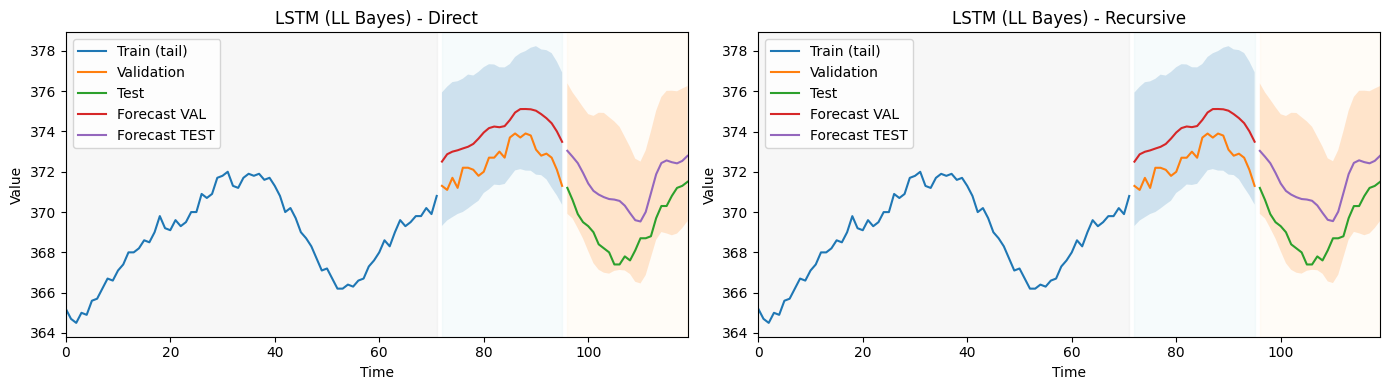

In [25]:
# Run the demo
if __name__ == "__main__":
    _ = demo_workflow(
        use_last_n=1040,
        context_len=52,
        horizon=24,
        standardize=True
    )